In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from symplecticEuler import *
from calcSpringForces import *

In [2]:
# Functions to produces matrices that perform rotations in three dimensions.
def rotZ(th):
    c = np.cos(th);
    s = np.sin(th);
    A = np.array([[c,-s,0],[s,c,0],[0,0,1]]);
    return A;
def rotX(th):
    c = np.cos(th);
    s = np.sin(th);
    A = np.array([[1,0,0],[0,c,-s],[0,s,c]]);
    return A;
def rotY(th):
    c = np.cos(th);
    s = np.sin(th);
    A = np.array([[c,0,-s],[0,1,0],[s,0,c]]);
    return A;

In [3]:
class Vertex:
    def __init__(self,pcoords):
        self.coords = pcoords;
        self.idNum = None;
        
    def __str__(self):
        return "vert:"+self.coords.__str__();
    def __repr__(self):
        return self.__str__();
    
class Strut:
    def __init__(self,v1,v2,stiffness=1.0,restLeng=None):
        self.v1 = v1;
        self.v2 = v2;
        self.stiffness = stiffness;
        if restLeng is None:
            self.restLeng = np.sqrt( np.sum((self.v1.coords - self.v2.coords)**2.) );
        else:
            self.restLeng = restLeng;
            
    def getLeng(self):
        return self.restLeng;

class StrutNodeStructure:
    def __init__(self):
        self.verts = [];
        self.struts = [];
        
    def addVerts(self,pcoords):
        vshape = pcoords.shape;
        if vshape[0]==3: # requires reshape
            pcoords = pcoords.T;
            Nverts = vshape[1];
        elif vshape[1]==3:
            Nverts = vshape[0];
        else:
            raise ValueError("Vertices matrix of wrong dimensions!");

        myverts = [];
        for vv in pcoords:
            myverts.append(Vertex(vv));
        self.verts.extend(myverts);
        return myverts;
            
    # pstruts should be a list of lists-of-length-2
    def addStruts(self,*args,**kwargs):
        
        #print(kwargs);
        #
        pstiffness = 1.0;
        if 'stiffness' in kwargs:
            pstiffness = kwargs['stiffness'];
        
        if len(args)==1: # list of struts
            newstruts = [];
            for strutverts in args[0]:
                mystrut = Strut( strutverts[0], strutverts[1], stiffness=pstiffness);
                newstruts.append(mystrut);
            self.struts.extend( newstruts );
            return args[0];
        elif len(args)==2:
            v1s = args[0];
            v2s = args[1];
            if len(v1s)==len(v2s):
                newstruts = [];
                for jj in range(len(v1s)):
                    mystrut = Strut( v1s[jj],v2s[jj], stiffness=pstiffness);
                    newstruts.append( mystrut );
                self.struts.extend(newstruts);
                return newstruts;
            else:
                raise ValueError("Dimension mismatch. Expected lists to be of same length");
        
        
        #self.struts.extend(pstruts);
    
    def getVertsXYZ(self):
        return np.array([v.coords for v in ralph.verts]).T;
    def setVertsXYZ(self,XYZ):
        for jj in np.arange(len(self.verts)):
            self.verts[jj].coords = XYZ[:,jj];
            
    def divulge(self):
        vertNum = 0;
        
        vertArray = np.zeros(shape=(0,3))
        for vert in self.verts:
            vertArray = np.vstack( (vertArray,vert.coords) );
            vert.idNum = vertNum;
            vertNum += 1;
        
        springList = [[strut.v1.idNum, strut.v2.idNum, strut.getLeng(), strut.stiffness] for strut in self.struts];
        springList = np.array(springList);
        
        return vertArray,springList;
        
        
    def plotverts(self,color='k',labelVerts=False):
        allverts = np.array([]).reshape(0,3);
        ax = plt.gca();
        for (jj,vert) in enumerate(self.verts):
            mycoords = vert.coords;
            allverts = np.vstack( (allverts,np.atleast_2d(mycoords)) );
            if labelVerts:
                ax.text(mycoords[0],mycoords[1],mycoords[2],'%d'%jj,color='red');
        plt.plot(allverts[:,0],allverts[:,1],allverts[:,2],'ko');
        
    def plotstruts(self,color='k'):
        for strut in self.struts:
            v1 = strut.v1.coords;
            v2 = strut.v2.coords;
            xyz = np.vstack( (v1,v2) );
            plt.plot(xyz[:,0],xyz[:,1],xyz[:,2],'k',linewidth=np.log10(strut.stiffness+1.0));
    
    def plot(self,color='k',labelVerts=False):
        self.plotverts(color=color,labelVerts=labelVerts);
        self.plotstruts(color=color);

In [4]:
def plotSpringMassSystem(verts,springList,detail=0,ax=None):
    verts = verts.reshape( (-1,3) );
    if ax is None:
        ax = plt.gca();
    if detail==0:
        inds1 = springList[:,0].astype('int');
        inds2 = springList[:,1].astype('int');

        mynans = np.full( (springList.shape[0]), float('nan') );

        XX = np.vstack( (verts[inds1,0],verts[inds2,0],mynans) ).T.flatten();
        YY = np.vstack( (verts[inds1,1],verts[inds2,1],mynans) ).T.flatten();
        ZZ = np.vstack( (verts[inds1,2],verts[inds2,2],mynans) ).T.flatten();

        ax.plot(XX,YY,ZZ,'k');
    elif detail==1:
        for spring in springList:
            coords = verts[spring[0:2].astype('int'),:];
            currlen = coords[0,:]-coords[1,:]; currlen = np.sqrt(np.dot(currlen,currlen));
            mylw = np.log10(spring[3]+10.);
            myc = 'g';
            if currlen < spring[2]:
                myc = (0.6,0,0);
            ax.plot(coords[:,0],coords[:,1],coords[:,2],'k',linewidth=mylw,color=myc);

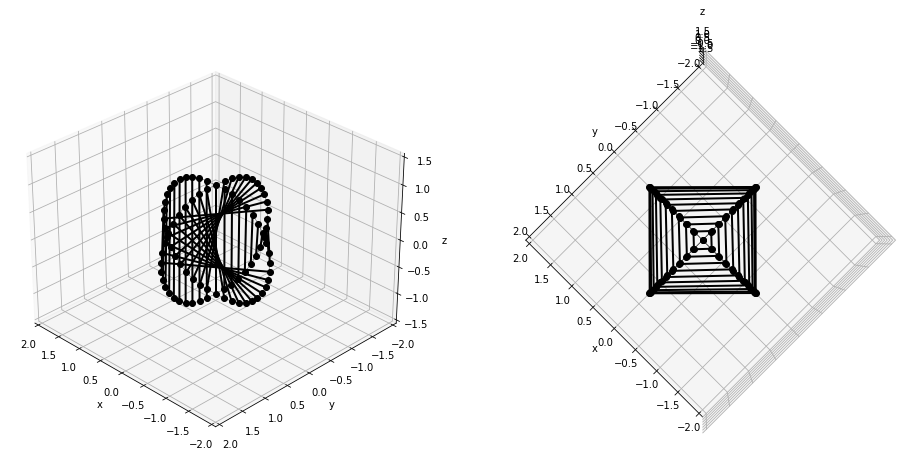

In [5]:
# fan

N = 4; # number of fans
M = 10; # half-number of nodes on each blade
ths = np.linspace(0,2.*np.pi/2.,2*M);
x = 0*ths;
y = np.sin(ths);
z = np.cos(ths);

blade_base = np.vstack( (x,y,z) );

my_model = StrutNodeStructure();
    
xyz = blade_base;
xyz[1,:] = xyz[1,:]+.2;
#xyz = rotY(-.2)@xyz;

blades = [];
rounds = [];
rotmat = rotZ(2.*np.pi/N);

# add the central strut. all blades connect to its nodes.
central_nodes = my_model.addVerts(np.array([[0,0,-1],[0,0,1]]).T);
my_model.addStruts( [central_nodes[0]], [central_nodes[1]], stiffness=100.);

for jj in range(N): # make the blades
    tmp = my_model.addVerts(xyz);
    blades.append(tmp);
    rounds.append(tmp);
    xyz = rotmat@xyz;
    my_model.addStruts( tmp[0:-1], tmp[1:] ); # tendons connecting each node in the blade
    my_model.addStruts( central_nodes, [tmp[-1],tmp[0]] ); # tendons connecting the blade to the central strut
    
for jj in range(N): # add struts to each blade
    jnext = (jj+1)%N;
    b1 = blades[jj];
    b2 = blades[jnext];
    my_model.addStruts( b1[0:M],b2[-1:(M-1):-1], stiffness=100.);

for strut in my_model.struts: # make all tendons short, so they contract the structure
    if strut.stiffness == 1.:
        strut.stiffness = 1.;
        #strut.restLeng = 0.95*strut.restLeng;
        strut.restLeng = .1;
        
#%matplotlib qt5
%matplotlib inline
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121, projection='3d')
my_model.plot(color='k',labelVerts=False);
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-1.5,1.5)
ax.view_init(30,135)
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z');

ax = fig.add_subplot(122, projection='3d')
my_model.plot(color='k',labelVerts=False);
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-1.5,1.5)
ax.view_init(90,135)
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z');

plt.show()

In [6]:
nodes,springList = my_model.divulge();

odeFun_dXdt = lambda X,V: V;
odeFun_dVdt = lambda X,V: calcSpringForces(X,springList)-1.*V;

tspan = np.arange(0,40,.1);
X_init = 1.0*nodes;
V_init = 0.0*nodes;
Xsol,Vsol = symplecticEuler(odeFun_dXdt,odeFun_dVdt,tspan,X_init.copy(),V_init);

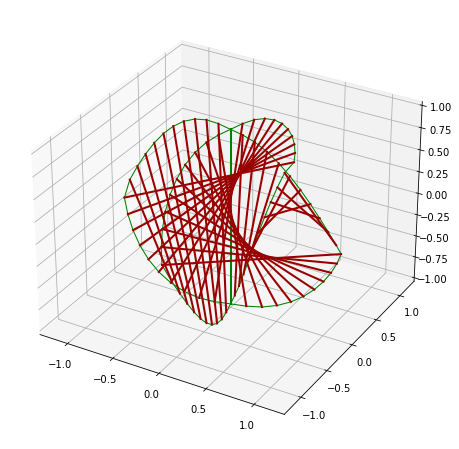

In [7]:
#%matplotlib qt5
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
plotSpringMassSystem(Xsol[:,-1],springList,detail=1);

In [8]:
# If qt5 enabled, this will produce an animation of the spring-mass system in time
%matplotlib qt5
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for kk in range(0,len(tspan),10):
    ax.cla();
    plotSpringMassSystem( Xsol[:,kk], springList, detail=0, ax=ax)
    
    ax.set_xlim3d(-1,1)
    ax.set_ylim3d(-1,1)
    ax.set_zlim3d(-1,1)
    
    plt.title("Time=%f"%tspan[kk]);
    plt.pause(0.03);

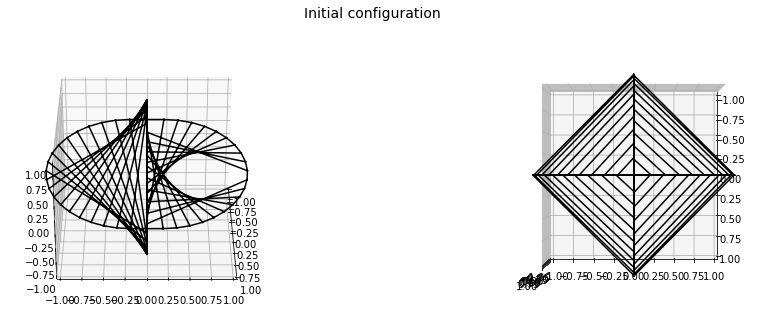

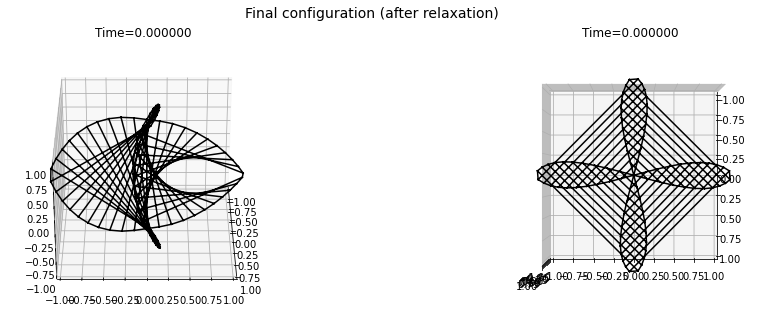

In [9]:
%matplotlib inline
X_final = Xsol[:,-1];


fig = plt.figure(figsize=(16,5))
plt.suptitle('Initial configuration',fontsize=14);

ax = fig.add_subplot(121, projection='3d')
plotSpringMassSystem( X_init, springList, detail=0, ax=ax)
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
ax.view_init(30,0)

ax = fig.add_subplot(122, projection='3d')
plotSpringMassSystem( X_init, springList, detail=0, ax=ax)
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
ax.view_init(90,0)
plt.show();


fig = plt.figure(figsize=(16,5))
plt.suptitle('Final configuration (after relaxation)',fontsize=14);

ax = fig.add_subplot(121, projection='3d')
plotSpringMassSystem( X_final, springList, detail=0, ax=ax)
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
ax.view_init(30,0)
plt.title("Time=%f"%tspan[0]);

ax = fig.add_subplot(122, projection='3d')
plotSpringMassSystem( X_final, springList, detail=0, ax=ax)
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
ax.view_init(90,0)
plt.title("Time=%f"%tspan[0]);
plt.show();